     TICKER PER       DATE      TIME   CLOSE
0      SBER   D 2020-01-01  00:00:00  255.00
1      SBER   D 2020-01-04  00:00:00  255.00
2      SBER   D 2020-01-07  00:00:00  253.90
3      SBER   D 2020-01-09  00:00:00  259.15
4      SBER   D 2020-01-10  00:00:00  257.99
...     ...  ..        ...       ...     ...
1265   SBER   D 2025-01-28  00:00:00  275.23
1266   SBER   D 2025-01-29  00:00:00  278.35
1267   SBER   D 2025-01-30  00:00:00  280.36
1268   SBER   D 2025-01-31  00:00:00  281.97
1269   SBER   D 2025-02-01  00:00:00  280.73

[1270 rows x 5 columns]
ДАННЫЕ с заполненными пропусками             target
2020-01-01  255.00
2020-01-02  255.00
2020-01-03  255.00
2020-01-04  255.00
2020-01-05  255.00
...            ...
2025-01-28  275.23
2025-01-29  278.35
2025-01-30  280.36
2025-01-31  281.97
2025-02-01  280.73

[1859 rows x 1 columns]
0       255.00
1       255.00
2       255.00
3       255.00
4       255.00
         ...  
1854    275.23
1855    278.35
1856    280.36
1857    281.97

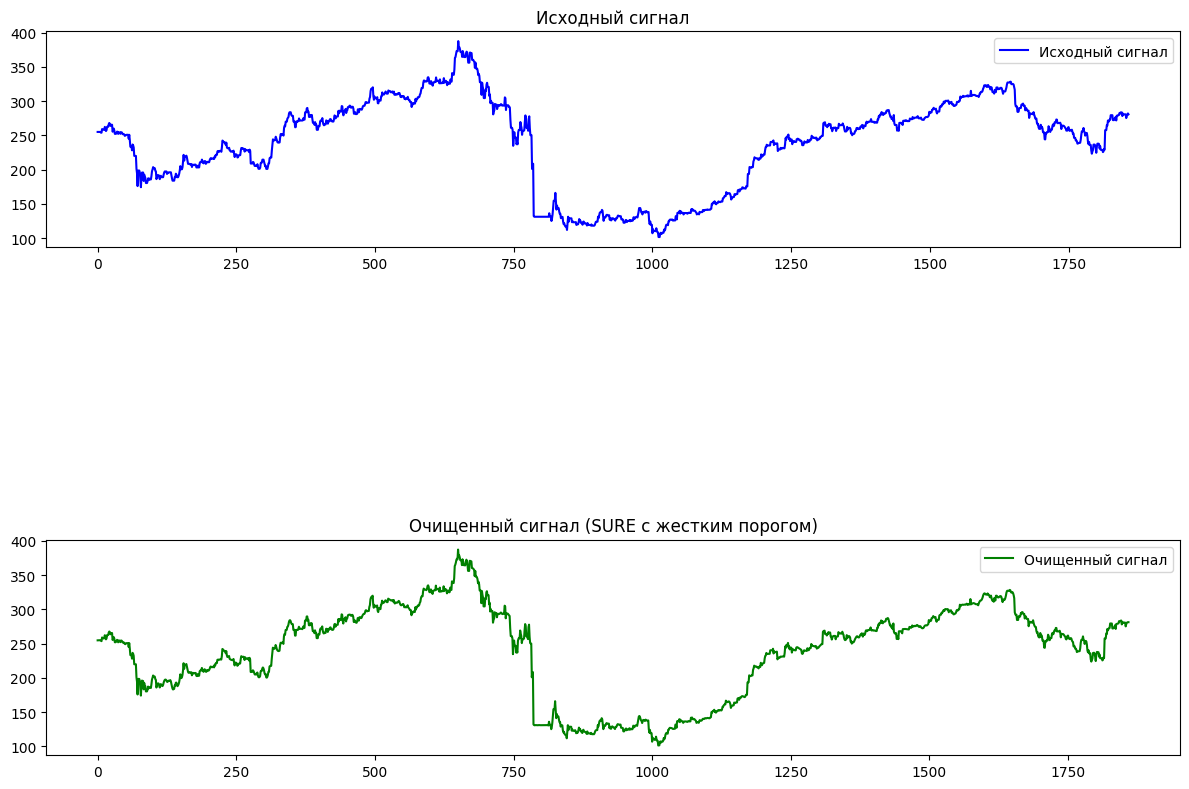

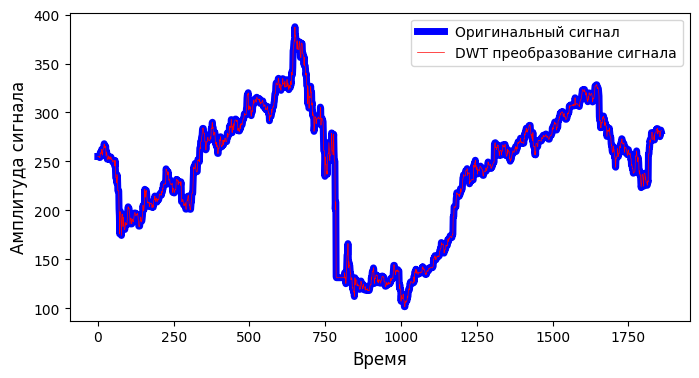

s=
 0       254.875446
1       254.921881
2       255.016923
3       255.160571
4       255.052402
           ...    
1855    278.528059
1856    280.482487
1857    281.071564
1858    281.366103
1859    281.366103
Length: 1860, dtype: float64


In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  pylab import *
import pywt
from pywt import wavedec

ticker = 'SBER'
df = pd.read_excel('SBER.xlsx')
print(df)
# Преобразование даты в правильный формат
df['DATE'] = pd.to_datetime(df['DATE'], format='%d.%m.%y')
# Создаем timestamp из даты (время в данных не используется)
df['timestamp'] = df['DATE']

# Создание DataFrame с необходимыми колонками
data = df[['timestamp','CLOSE']].rename(columns={'CLOSE': 'target'})
data = data.set_index('timestamp')
# Создаем регулярный временной ряд
full_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
data = data.reindex(full_dates)

# Интерполяция пропущенных значений
data = data.ffill()
print('ДАННЫЕ с заполненными пропусками', data)

data = data.reset_index()
dclose=data['target']
print(dclose)


#выбор наилучшего вейвлета по минимуму энтропии, глубина разложения всех вейвлетов = 4
def wavelet(data):
    wavlist = pywt.wavelist(kind='discrete')
    mat = []
    for waveletname in wavlist:
        coeffs = wavedec(data, waveletname, level=4)
        cA4,cD4, cD3,cD2,cD1=coeffs
        e1=sum([x**2 for x in cD1])
        e2 = sum([x ** 2 for x in cD2])
        e3 = sum([x ** 2 for x in cD3])
        e4 = sum([x ** 2 for x in cD4])
        p1=e1/(e1+e2+e3+e4)
        p2 = e2 / (e1 + e2 + e3 + e4)
        p3 = e3 / (e1 + e2 + e3 + e4)
        p4 = e4 / (e1 + e2 + e3 + e4)
        WE=-(p1*math.log(p1)+p2*math.log(p2)+p3*math.log(p3)+p4*math.log(p4))
        mat.append(WE)
    z = pd.DataFrame([wavlist, mat]).T
    z.columns=['name','WE']
    best_w = z[z['WE'] == z['WE'].min()]
    print(best_w)
    return best_w['name'].iloc[0]

print("best w= \n", wavelet(dclose))

def sure_threshold(coeffs):
    N = len(coeffs)
    coeffs_sorted = np.sort(np.abs(coeffs))[::-1]  # Сортируем коэффициенты по убыванию
    risk = np.zeros(N)

    for i in range(N):
        t = coeffs_sorted[i]
        risk[i] = N - 2 * np.sum(np.abs(coeffs) <= t) + np.sum(np.minimum(np.abs(coeffs), t) ** 2)

    # Находим порог, минимизирующий SURE
    optimal_threshold = coeffs_sorted[np.argmin(risk)]
    return optimal_threshold
wavelet = wavelet(dclose)
level = 4  # Уровень декомпозиции
coeffs = pywt.wavedec(dclose, wavelet, level=level)

# Применение SURE с жестким порогом
coeffs_thresh = []
for i in range(1, len(coeffs)):  # Игнорируем аппроксимирующие коэффициенты
    threshold = sure_threshold(coeffs[i])
    coeffs_thresh.append(pywt.threshold(coeffs[i], threshold, mode='hard'))
coeffs_thresh = [coeffs[0]] + coeffs_thresh  # Добавляем аппроксимирующие коэффициенты

# Обратное вейвлет-преобразование
denoised_signal = pywt.waverec(coeffs_thresh, wavelet)

# Визуализация результатов
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(dclose, label='Исходный сигнал', color='blue')
plt.legend()
plt.title('Исходный сигнал')



plt.subplot(3, 1, 3)
plt.plot(denoised_signal, label='Очищенный сигнал', color='green')
plt.legend()
plt.title('Очищенный сигнал (SURE с жестким порогом)')

plt.tight_layout()
plt.show()
fig, ax = subplots(figsize=(8,4))
ax.plot(dclose, 'b', linewidth=5,label='Оригинальный сигнал')
rec = denoised_signal
ax.plot(rec, 'r', label='DWT преобразование сигнала', linewidth=0.5, linestyle='-')
ax.legend()
#ax.set_title('Удаление высокочастотного шума с помощью вейвлета :%s\n для пороговой функции:%s'%(v,w), fontsize=12)
ax.set_ylabel('Амплитуда сигнала', fontsize=12)
ax.set_xlabel('Время', fontsize=12)
show()

s = pd.Series(rec)
print("s=\n",s)
#s.to_csv('/Users/liliahajrullina/Desktop/paper_new/мартовские статьи/Данные/очищ_СБЕР.csv', index=False)